In [ ]:
# ===============================
# 0. 환경 설정: GPU, Mixed Precision, Google Drive 마운트
# ===============================
import tensorflow as tf
print("GPU devices:", tf.config.list_physical_devices('GPU'))

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Google Drive 마운트 (Colab 환경)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q -U keras-tuner
!pip install -U shap

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.mixed_precision import set_global_policy
import os
import keras_tuner as kt  # Keras Tuner import

# GPU 메모리 최적화를 위해 float16 사용
set_global_policy('mixed_float16')

In [ ]:
# -------------------------------------------------------------------------------------
# 데이터 로드 및 전처리 (기존 코드와 동일)
# -------------------------------------------------------------------------------------
normal_data_arr = "/content/drive/My Drive/list/train_normal_arr.npy"
caution_data_arr = "/content/drive/My Drive/list/train_caution_arr.npy"
defect_data_arr = "/content/drive/My Drive/list/train_defect_arr.npy"

test_normal_data_arr = "/content/drive/My Drive/list/test_normal_arr.npy"
test_caution_data_arr = "/content/drive/My Drive/list/test_caution_arr.npy"
test_defect_data_arr = "/content/drive/My Drive/list/test_defect_arr.npy"

# Load data from the file paths using np.load
normal_arr = np.load(normal_data_arr)
caution_arr = np.load(caution_data_arr)
defect_arr = np.load(defect_data_arr)

test_normal_arr = np.load(test_normal_data_arr)
test_caution_arr = np.load(test_caution_data_arr)
test_defect_arr = np.load(test_defect_data_arr)

# 데이터 shape 확인
print("normal_arr shape:", normal_arr.shape)
print("caution_arr shape:", caution_arr.shape)
print("defect_arr shape:", defect_arr.shape)

# 슬라이딩 윈도우 생성 함수 (기존 코드와 동일)
def create_sliding_windows(arr, window_size=100, step=30):
    n_rows = arr.shape[0]
    windows = []
    for i in range(0, n_rows - window_size + 1, step):
        windows.append(arr[i:i+window_size])
    return np.array(windows)


# 학습 데이터 슬라이딩 윈도우 적용
normal_windows = create_sliding_windows(normal_arr, window_size=100, step=30)
caution_windows = create_sliding_windows(caution_arr, window_size=100, step=30)
defect_windows = create_sliding_windows(defect_arr, window_size=100, step=30)

# 테스트 데이터 슬라이딩 윈도우 적용
test_normal_windows = create_sliding_windows(test_normal_arr, window_size=100, step=30)
test_caution_windows = create_sliding_windows(test_caution_arr, window_size=100, step=30)
test_defect_windows = create_sliding_windows(test_defect_arr, window_size=100, step=30)

# 각 데이터별 라벨 생성
normal_labels = np.zeros(len(normal_windows))
caution_labels = np.ones(len(caution_windows))
defect_labels = np.full(len(defect_windows), 2)

test_normal_labels = np.zeros(len(test_normal_windows))
test_caution_labels = np.ones(len(test_caution_windows))
test_defect_labels = np.full(len(test_defect_windows), 2)

# 모든 윈도우 데이터를 concat (axis=0)하여 하나의 X 배열 생성
X_train = np.concatenate([normal_windows, caution_windows, defect_windows], axis=0)
y_train = np.concatenate([normal_labels, caution_labels, defect_labels], axis=0)

X_test = np.concatenate([test_normal_windows, test_caution_windows, test_defect_windows], axis=0)
y_test = np.concatenate([test_normal_labels, test_caution_labels, test_defect_labels], axis=0)

# X_train, y_train shape 확인
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# -------------------------------------------------------------------------------------
# 데이터 보강 (Scaling)
# -------------------------------------------------------------------------------------
def scale_data(arr, scale_factor=1.1):
    """데이터의 진폭을 변경합니다."""
    return arr * scale_factor

# 학습 데이터에 Scaling 적용 (일부 데이터에만 적용하여 데이터 불균형 해소)
num_to_augment = len(normal_windows) // 2  # Normal 데이터의 절반만 보강
augmented_normal_windows = scale_data(normal_windows[:num_to_augment])
X_train = np.concatenate([X_train, augmented_normal_windows], axis=0)
y_train = np.concatenate([y_train, np.zeros(len(augmented_normal_windows))], axis=0)

print("Augmented X_train shape:", X_train.shape)
print("Augmented y_train shape:", y_train.shape)

# MinMaxScaler를 사용하여 데이터 스케일링 (모델 학습 전에 수행)
scaler = MinMaxScaler()

# 2차원 형태로 변환 후 스케일링
original_shape = X_train.shape
X_train = X_train.reshape(-1, X_train.shape[-1])  # 2차원 형태로 변환
X_train = scaler.fit_transform(X_train)  # 스케일링 수행
X_train = X_train.reshape(original_shape)  # 원래 형태로 복원

original_shape_test = X_test.shape
X_test = X_test.reshape(-1, X_test.shape[-1])  # 2차원 형태로 변환
X_test = scaler.transform(X_test)  # 스케일링 수행
X_test = X_test.reshape(original_shape_test)  # 원래 형태로 복원


normal_arr shape: (770977, 98)
caution_arr shape: (584051, 98)
defect_arr shape: (584498, 98)
X_train shape: (64642, 100, 98)
y_train shape: (64642,)
X_test shape: (8101, 100, 98)
y_test shape: (8101,)
Augmented X_train shape: (77490, 100, 98)
Augmented y_train shape: (77490,)


In [ ]:
# -------------------------------------------------------------------------------------
# Attention Layer (기존 AttentionLayer 활용)
# -------------------------------------------------------------------------------------
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):  # call 함수의 self 파라미터 추가
        # Alignment scores 계산
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        # Attention weights 계산 (softmax 적용)
        a = tf.keras.backend.softmax(e, axis=1)
        # Weighted sum of LSTM outputs
        output = x * a
        self.attention_weights = a  # Attention 가중치 저장
        return tf.keras.backend.sum(output, axis=1)  # attention value

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# -------------------------------------------------------------------------------------
# 모델 구축 함수 (Keras Tuner 사용)
# -------------------------------------------------------------------------------------
def build_model(hp):
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = 3

    inputs = Input(shape=input_shape)
    x = inputs

    # LSTM 레이어 수 (2~4)
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=2, max_value=4, step=1)
    for i in range(num_lstm_layers):
        # LSTM 유닛 수 (64~256)
        lstm_units = hp.Int(f'lstm_units_{i}', min_value=64, max_value=256, step=32)
        x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)

        # Dropout 비율 (0.1~0.5)
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
        x = Dropout(dropout_rate)(x)

    # Attention 레이어
    attention_out = AttentionLayer()(x)

    # Fully Connected 레이어
    output = Dense(num_classes, activation='softmax')(attention_out)

    model = Model(inputs=inputs, outputs=output)

    # Learning Rate (1e-4 ~ 1e-2)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    OPTIMIZER = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)  # AdamW 사용

    model.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# -------------------------------------------------------------------------------------
# Keras Tuner 설정
# -------------------------------------------------------------------------------------
BATCH_SIZE = 16  # BATCH_SIZE 정의

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # 시도 횟수
    directory='keras_tuner_dir',  # 튜너 결과 저장 디렉토리
    project_name='lstm_tuner',
    overwrite=True  # 이전 튜닝 결과 덮어쓰기
)

# Early Stopping (Keras Tuner 용)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) #튜닝 시간이 너무 길어지는 것을 방지

# -------------------------------------------------------------------------------------
# Keras Tuner 탐색
# -------------------------------------------------------------------------------------
print("Keras Tuner 탐색 시작...")
tuner.search(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping]) #튜닝 시간이 너무 길어지는 것을 방지

# -------------------------------------------------------------------------------------
# 최적 모델 가져오기
# -------------------------------------------------------------------------------------
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# -------------------------------------------------------------------------------------
# 최적 하이퍼파라미터 출력
# -------------------------------------------------------------------------------------
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("최적 하이퍼파라미터:")
print(best_hyperparameters.values)

Trial 10 Complete [00h 20m 13s]
val_accuracy: 0.8290101885795593

Best val_accuracy So Far: 0.9036650061607361
Total elapsed time: 02h 53m 33s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 98)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │         232,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100, 320)            │         533,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 320)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 320)                 │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             963 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 767,591 (2.93 MB)

 Trainable params: 767,591 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

최적 하이퍼파라미터:
{'num_lstm_layers': 2, 'lstm_units_0': 128, 'dropout_rate_0': 0.4, 'lstm_units_1': 160, 'dropout_rate_1': 0.30000000000000004, 'learning_rate': 0.0010675513850020228, 'lstm_units_2': 192, 'dropout_rate_2': 0.4}


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.mixed_precision import set_global_policy
import os
import keras_tuner as kt  # Keras Tuner import
from tensorflow.keras.regularizers import l2 # L2 Regularizer import

In [ ]:
# -------------------------------------------------------------------------------------
# Learning Rate Scheduler (튜닝 후, 최적 모델에 적용)
# -------------------------------------------------------------------------------------
def lr_scheduler(epoch):
    """학습률 스케줄러 함수 (지수 감쇠)"""
    initial_lr = best_hyperparameters.values['learning_rate']  # Keras Tuner가 찾은 최적 learning rate 사용
    decay_rate = 0.9
    return initial_lr * (decay_rate ** epoch)

lr_callback = LearningRateScheduler(lr_scheduler, verbose=0) # verbose=1: 매 epoch마다 학습률 출력

# -------------------------------------------------------------------------------------
# Early Stopping (튜닝 후, 최적 모델에 적용)
# -------------------------------------------------------------------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# -------------------------------------------------------------------------------------
# 모델 재학습 (튜닝만 된 모델)
# -------------------------------------------------------------------------------------
print("튜닝만 된 모델 재학습 시작...")
# Get the learning rate from the best hyperparameters
learning_rate = best_hyperparameters.values['learning_rate']
# Recreate the optimizer with the best learning rate
OPTIMIZER = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)  # AdamW 사용

best_model.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['accuracy']) #모델을 불러왔기 때문에 컴파일을 다시 해줘야함
history_tuned = best_model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_split=0.2,
                         callbacks=[early_stopping, lr_callback])

# -------------------------------------------------------------------------------------
# 모델 평가 (튜닝만 된 모델)
# -------------------------------------------------------------------------------------
loss_tuned, accuracy_tuned = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (Tuned Only): {loss_tuned:.4f}')
print(f'Test Accuracy (Tuned Only): {accuracy_tuned:.4f}')




튜닝만 된 모델 재학습 시작...
Epoch 1/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 88s 22ms/step - accuracy: 0.9516 - loss: 0.1449 - val_accuracy: 0.8899 - val_loss: 0.5117 - learning_rate: 0.0011
Epoch 2/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9335 - loss: 0.1841 - val_accuracy: 0.8848 - val_loss: 0.4715 - learning_rate: 9.6080e-04
Epoch 3/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9660 - loss: 0.1014 - val_accuracy: 0.8930 - val_loss: 0.6135 - learning_rate: 8.6472e-04
Epoch 4/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9691 - loss: 0.0904 - val_accuracy: 0.9189 - val_loss: 0.4476 - learning_rate: 7.7824e-04
Epoch 5/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9791 - loss: 0.0592 - val_accuracy: 0.9063 - val_loss: 0.7089 - learning_rate: 7.0042e-04
Epoch 6/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9857 - loss: 0.0415 - val_accuracy: 0.8914 - val_loss: 0.7213 - learning_rate: 6.3038e-04
Epoch 7/50
3875/3875 ━━━━

In [ ]:
# -------------------------------------------------------------------------------------
# 모델 불러오기 및 Regularization 추가
# -------------------------------------------------------------------------------------


def add_regularization(model, regularizer=l2(0.001)):
    for layer in model.layers:
        if isinstance(layer, (Dense, LSTM, Bidirectional)):
            if hasattr(layer, 'kernel_regularizer'):
                layer.kernel_regularizer = regularizer
            if hasattr(layer, 'bias_regularizer'):
                layer.bias_regularizer = regularizer
    return model

best_model_regularized = add_regularization(best_model)  # Apply regularization to the best_model

# -------------------------------------------------------------------------------------
# 모델 재컴파일 (Regularization 추가)
# -------------------------------------------------------------------------------------
best_model_regularized.compile(optimizer=OPTIMIZER, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# -------------------------------------------------------------------------------------
# 모델 재학습 (Regularization 추가)
# -------------------------------------------------------------------------------------
print("Regularization 추가된 모델 재학습 시작...")
history_regularized = best_model_regularized.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, validation_split=0.2,
                         callbacks=[early_stopping, lr_callback])

# -------------------------------------------------------------------------------------
# 모델 평가 (Regularization 추가)
# -------------------------------------------------------------------------------------
loss_regularized, accuracy_regularized = best_model_regularized.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (Regularized): {loss_regularized:.4f}')
print(f'Test Accuracy (Regularized): {accuracy_regularized:.4f}')

# -------------------------------------------------------------------------------------
# 결과 비교 및 최종 모델 선택
# -------------------------------------------------------------------------------------
print("\n--------------------------------------------------")
print("모델 성능 비교:")
print(f"Tuned Only - Loss: {loss_tuned:.4f}, Accuracy: {accuracy_tuned:.4f}")
print(f"Regularized - Loss: {loss_regularized:.4f}, Accuracy: {accuracy_regularized:.4f}")
print("--------------------------------------------------\n")

if accuracy_regularized > accuracy_tuned:
    print("Regularization 추가된 모델이 더 높은 정확도를 보입니다.")
    final_model = best_model_regularized
    final_model_name = "best_model_regularized"
else:
    print("튜닝만 된 모델이 더 높은 정확도를 보입니다.")
    final_model = best_model
    final_model_name = "best_model_tuned"

print(f"최종 모델로 {final_model_name} 선택됨")



Regularization 추가된 모델 재학습 시작...
Epoch 1/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 85s 21ms/step - accuracy: 0.9398 - loss: 0.1620 - val_accuracy: 0.9141 - val_loss: 0.6135 - learning_rate: 0.0011
Epoch 2/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9590 - loss: 0.1218 - val_accuracy: 0.9157 - val_loss: 0.6048 - learning_rate: 9.6080e-04
Epoch 3/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9228 - loss: 0.1939 - val_accuracy: 0.9056 - val_loss: 0.7689 - learning_rate: 8.6472e-04
Epoch 4/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9633 - loss: 0.1079 - val_accuracy: 0.9121 - val_loss: 0.7559 - learning_rate: 7.7824e-04
Epoch 5/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9726 - loss: 0.0825 - val_accuracy: 0.9190 - val_loss: 0.7375 - learning_rate: 7.0042e-04
Epoch 6/50
3875/3875 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.9809 - loss: 0.0559 - val_accuracy: 0.7003 - val_loss: 0.9352 - learning_rate: 6.3038e-04
Epoch 7/50
3

In [ ]:
# 모델 저장 경로 설정 (Google Drive)
save_dir = "/content/drive/My Drive/saved_models"  # Google Drive의 저장 경로를 지정해 주세요.
os.makedirs(save_dir, exist_ok=True)  # 경로가 없으면 생성합니다.

# 튜닝만 된 모델 저장
tuned_model_path = os.path.join(save_dir, "tuned_model.keras") # .keras 확장자 추가
best_model.save(tuned_model_path)
print(f"튜닝만 된 모델 저장 완료: {tuned_model_path}")

# Regularization 추가된 모델 저장
regularized_model_path = os.path.join(save_dir, "regularized_model.keras") # .keras 확장자 추가
best_model_regularized.save(regularized_model_path)
print(f"Regularization 추가된 모델 저장 완료: {regularized_model_path}")

튜닝만 된 모델 저장 완료: /content/drive/My Drive/saved_models/tuned_model.keras
Regularization 추가된 모델 저장 완료: /content/drive/My Drive/saved_models/regularized_model.keras


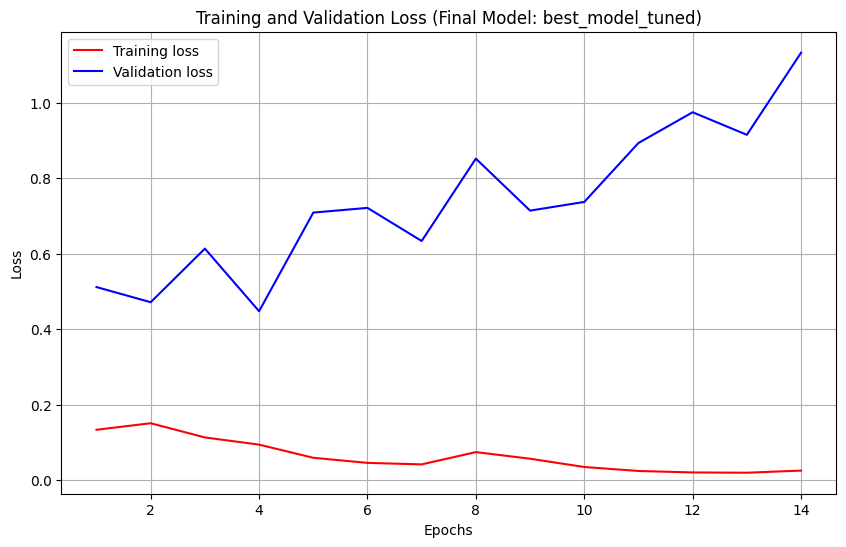

Test Loss (Final Model): 0.1747
Test Accuracy (Final Model): 0.9658
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Classification Report (Final Model):
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      3317
         1.0       0.96      0.96      0.96      2408
         2.0       0.95      0.93      0.94      2376

    accuracy                           0.97      8101
   macro avg       0.96      0.96      0.96      8101
weighted avg       0.97      0.97      0.97      8101



In [ ]:
# -------------------------------------------------------------------------------------
# Learning Curve 시각화 (선택된 최종 모델)
# -------------------------------------------------------------------------------------
# (적절한 history 선택: history_tuned 또는 history_regularized)
if final_model_name == "best_model_tuned":
    loss = history_tuned.history['loss']
    val_loss = history_tuned.history['val_loss']
else:
    loss = history_regularized.history['loss']
    val_loss = history_regularized.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'Training and Validation Loss (Final Model: {final_model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------------------------------
# 최종 모델 평가 및 분석
# -------------------------------------------------------------------------------------
num_classes = 3  # 클래스 수 정의

# 최종 모델 평가 및 예측
loss_final, accuracy_final = final_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (Final Model): {loss_final:.4f}')
print(f'Test Accuracy (Final Model): {accuracy_final:.4f}')

y_pred_final = final_model.predict(X_test)
y_pred_classes_final = np.argmax(y_pred_final, axis=1)

# Classification Report (Precision, Recall, F1-score)
print("Classification Report (Final Model):")
print(classification_report(y_test, y_pred_classes_final))

In [ ]:
# 모델 저장 경로 설정 (Google Drive)
model_save_path = "/content/drive/My Drive/saved_models/"  # Google Drive 경로로 변경
os.makedirs(model_save_path, exist_ok=True)  # 디렉토리가 없으면 생성

# 최종 모델 저장
final_model_filepath = os.path.join(model_save_path, f"{final_model_name}.h5")
final_model.save(final_model_filepath)

print(f"최종 모델 저장 완료: {final_model_filepath}")


최종 모델 저장 완료: /content/drive/My Drive/saved_models/best_model_tuned.h5


In [ ]:
# -------------------------------------------------------------------------------------
# Attention Score 추출 및 저장
# -------------------------------------------------------------------------------------
# Attention 가중치를 얻기 위한 새로운 모델 정의
attention_layer = [layer for layer in best_model.layers if isinstance(layer, AttentionLayer)][0] # AttentionLayer 객체 가져오기

# Attention 가중치 추출 모델 정의
# Instead of using attention_layer.attention_weights directly,
# get the output of the AttentionLayer during the call.
attention_model = Model(inputs=best_model.input,
                                          outputs=attention_layer.output) # Use attention_layer.output

# 테스트 데이터에 대한 Attention 가중치 추출
attention_weights = attention_model.predict(X_test)

# Attention 가중치 저장
attention_weights_save_path = "/content/drive/My Drive/lstm_tuner_attention_weights.npy"
np.save(attention_weights_save_path, attention_weights)
print(f"튜닝된 Attention 가중치 저장 완료: ")

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
튜닝된 Attention 가중치 저장 완료: 


In [ ]:
# prompt: 세션이 종료되서 아래의 셀에서 발생한 에러를 해결할 코드가 필요해

import tensorflow as tf
from google.colab import drive
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.mixed_precision import set_global_policy
import os
from tensorflow.keras.regularizers import l2 # L2 Regularizer import

# Mount Google Drive
drive.mount('/content/drive')

# -------------------------------------------------------------------------------------
# 데이터 로드 및 전처리 (기존 코드와 동일)
# -------------------------------------------------------------------------------------
normal_data_arr = "/content/drive/My Drive/list/train_normal_arr.npy"
caution_data_arr = "/content/drive/My Drive/list/train_caution_arr.npy"
defect_data_arr = "/content/drive/My Drive/list/train_defect_arr.npy"

test_normal_data_arr = "/content/drive/My Drive/list/test_normal_arr.npy"
test_caution_data_arr = "/content/drive/My Drive/list/test_caution_arr.npy"
test_defect_data_arr = "/content/drive/My Drive/list/test_defect_arr.npy"

# Load data from the file paths using np.load
normal_arr = np.load(normal_data_arr)
caution_arr = np.load(caution_data_arr)
defect_arr = np.load(defect_data_arr)

test_normal_arr = np.load(test_normal_data_arr)
test_caution_arr = np.load(test_caution_data_arr)
test_defect_arr = np.load(test_defect_data_arr)

# 데이터 shape 확인
print("normal_arr shape:", normal_arr.shape)
print("caution_arr shape:", caution_arr.shape)
print("defect_arr shape:", defect_arr.shape)

# 슬라이딩 윈도우 생성 함수 (기존 코드와 동일)
def create_sliding_windows(arr, window_size=100, step=30):
    n_rows = arr.shape[0]
    windows = []
    for i in range(0, n_rows - window_size + 1, step):
        windows.append(arr[i:i+window_size])
    return np.array(windows)


# 학습 데이터 슬라이딩 윈도우 적용
normal_windows = create_sliding_windows(normal_arr, window_size=100, step=30)
caution_windows = create_sliding_windows(caution_arr, window_size=100, step=30)
defect_windows = create_sliding_windows(defect_arr, window_size=100, step=30)

# 테스트 데이터 슬라이딩 윈도우 적용
test_normal_windows = create_sliding_windows(test_normal_arr, window_size=100, step=30)
test_caution_windows = create_sliding_windows(test_caution_arr, window_size=100, step=30)
test_defect_windows = create_sliding_windows(test_defect_arr, window_size=100, step=30)

# 각 데이터별 라벨 생성
normal_labels = np.zeros(len(normal_windows))
caution_labels = np.ones(len(caution_windows))
defect_labels = np.full(len(defect_windows), 2)

test_normal_labels = np.zeros(len(test_normal_windows))
test_caution_labels = np.ones(len(test_caution_windows))
test_defect_labels = np.full(len(test_defect_windows), 2)

# 모든 윈도우 데이터를 concat (axis=0)하여 하나의 X 배열 생성
X_train = np.concatenate([normal_windows, caution_windows, defect_windows], axis=0)
y_train = np.concatenate([normal_labels, caution_labels, defect_labels], axis=0)

X_test = np.concatenate([test_normal_windows, test_caution_windows, test_defect_windows], axis=0)
y_test = np.concatenate([test_normal_labels, test_caution_labels, test_defect_labels], axis=0)

# X_train, y_train shape 확인
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# -------------------------------------------------------------------------------------
# 데이터 보강 (Scaling)
# -------------------------------------------------------------------------------------
def scale_data(arr, scale_factor=1.1):
    """데이터의 진폭을 변경합니다."""
    return arr * scale_factor

# 학습 데이터에 Scaling 적용 (일부 데이터에만 적용하여 데이터 불균형 해소)
num_to_augment = len(normal_windows) // 2  # Normal 데이터의 절반만 보강
augmented_normal_windows = scale_data(normal_windows[:num_to_augment])
X_train = np.concatenate([X_train, augmented_normal_windows], axis=0)
y_train = np.concatenate([y_train, np.zeros(len(augmented_normal_windows))], axis=0)

print("Augmented X_train shape:", X_train.shape)
print("Augmented y_train shape:", y_train.shape)

# MinMaxScaler를 사용하여 데이터 스케일링 (모델 학습 전에 수행)
scaler = MinMaxScaler()

# 2차원 형태로 변환 후 스케일링
original_shape = X_train.shape
X_train = X_train.reshape(-1, X_train.shape[-1])  # 2차원 형태로 변환
X_train = scaler.fit_transform(X_train)  # 스케일링 수행
X_train = X_train.reshape(original_shape)  # 원래 형태로 복원

original_shape_test = X_test.shape
X_test = X_test.reshape(-1, X_test.shape[-1])  # 2차원 형태로 변환
X_test = scaler.transform(X_test)  # 스케일링 수행
X_test = X_test.reshape(original_shape_test)  # 원래 형태로 복원


Mounted at /content/drive
normal_arr shape: (770977, 98)
caution_arr shape: (584051, 98)
defect_arr shape: (584498, 98)
X_train shape: (64642, 100, 98)
y_train shape: (64642,)
X_test shape: (8101, 100, 98)
y_test shape: (8101,)
Augmented X_train shape: (77490, 100, 98)
Augmented y_train shape: (77490,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# Import the AttentionLayer class
from tensorflow.keras.layers import Layer # Import Layer

class AttentionLayer(Layer): # Define the AttentionLayer class
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):  # call 함수의 self 파라미터 추가
        # Alignment scores 계산
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        # Attention weights 계산 (softmax 적용)
        a = tf.keras.backend.softmax(e, axis=1)
        # Weighted sum of LSTM outputs
        output = x * a
        self.attention_weights = a  # Attention 가중치 저장
        return tf.keras.backend.sum(output, axis=1)  # attention value

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# 모델 저장 경로 (Google Drive)
model_save_path = "/content/drive/My Drive/saved_models/"

# 최종 모델 이름 (best_model_regularized 또는 best_model_tuned)
final_model_name = "best_model_tuned" # Use the correct name

# 모델 로드
final_model_filepath = os.path.join(model_save_path, f"{final_model_name}.h5")

# Check if the model file exists
if os.path.exists(final_model_filepath):
    loaded_model = load_model(final_model_filepath, custom_objects={'AttentionLayer': AttentionLayer})
    print(f"모델 로드 완료: {final_model_filepath}")
else:
    print(f"Error: Model file not found at {final_model_filepath}")
    print("Please re-train and save your model or check the file path.")

모델 로드 완료: /content/drive/My Drive/saved_models/best_model_tuned.h5


In [ ]:
!pip install -q shap
import shap
import numpy as np
import matplotlib.pyplot as plt

# ... (데이터 로딩, 전처리, 모델 로딩 코드 생략) ...

# 1. 샘플 수 줄이기 (10개 → 1개)
X_test_for_shap = X_test[:1]  # 3D 형태 유지: (samples, time_steps, features)

# 2. 배경 데이터 크기 줄이기 (100개 → 50개)
background_idx = np.random.choice(X_train.shape[0], 50, replace=False)
background_data = X_train[background_idx]  # 3D 형태 유지

# 3. 모델 래퍼 함수 정의 (3D 입력 처리)
def model_wrapper(x):
    x_reshaped = x.reshape(-1, X_test.shape[1], X_test.shape[2])  # 3D로 변환
    predictions = loaded_model.predict(x_reshaped)
    return predictions

# 2D로 변환된 배경 데이터 준비
background_data_reshaped = background_data.reshape(background_data.shape[0], -1)
explainer = shap.KernelExplainer(model_wrapper, background_data_reshaped)

# 4. SHAP 값 계산 (배치 크기 지정)
X_test_for_shap_reshaped = X_test_for_shap.reshape(X_test_for_shap.shape[0], -1)
shap_values = explainer.shap_values(X_test_for_shap_reshaped, batch_size=32)  # 배치 크기 추가

# 5. SHAP 값 시각화
shap_values_reshaped = shap_values.reshape(shap_values.shape[0], X_test_for_shap.shape[1], X_test_for_shap.shape[2])
shap.summary_plot(shap_values_reshaped[0], X_test_for_shap, plot_type="bar")
plt.title("SHAP Summary Plot for Class 0")
plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [ ]:
#위의 SHAP계산에서 자꾸 RAM용량 부족이 뜨는것 같다. attention기반 모델에서는 잘 안된다더니 진짜인거 같다.

튜닝된 Attention 가중치 로드 완료: /content/drive/My Drive/lstm_tuner_attention_weights.npy


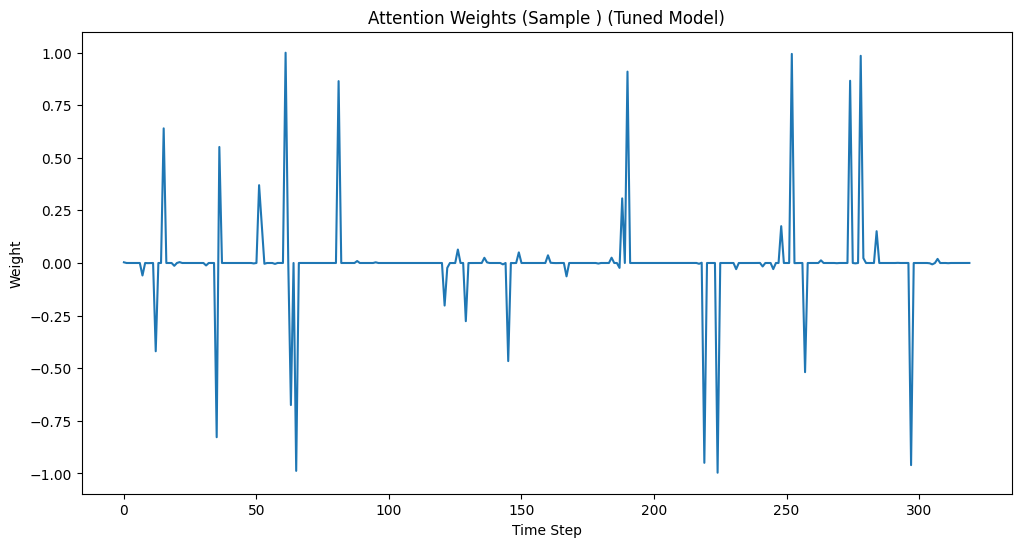

Top  Time Steps: 


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# Import the AttentionLayer class
from tensorflow.keras.layers import Layer # Import Layer
import matplotlib.pyplot as plt
import numpy as np
import os

class AttentionLayer(Layer): # Define the AttentionLayer class
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                    initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                    initializer="zeros", trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):  # call 함수의 self 파라미터 추가
        # Alignment scores 계산
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        # Attention weights 계산 (softmax 적용)
        a = tf.keras.backend.softmax(e, axis=1)
        # Weighted sum of LSTM outputs
        output = x * a
        self.attention_weights = a  # Attention 가중치 저장
        return tf.keras.backend.sum(output, axis=1)  # attention value

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Load the model
model_save_path = "/content/drive/My Drive/saved_models/"
final_model_name = "best_model_tuned"
final_model_filepath = os.path.join(model_save_path, f"{final_model_name}.h5")
loaded_model = load_model(final_model_filepath, custom_objects={'AttentionLayer': AttentionLayer})


# Load attention weights from file
attention_weights_save_path = "/content/drive/My Drive/lstm_tuner_attention_weights.npy"
attention_weights = np.load(attention_weights_save_path)
print(f"튜닝된 Attention 가중치 로드 완료: {attention_weights_save_path}")

# 샘플 선택
sample_index = 0  # 분석할 샘플 인덱스

# Attention 가중치 시각화 (샘플 선택)
plt.figure(figsize=(12, 6))
plt.plot(attention_weights[sample_index])
plt.title(f"Attention Weights (Sample ) (Tuned Model)")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.show()

# 주요 feature 확인
top_n = 50  # 가장 높은 attention weight를 가진 time step 개수
top_indices = np.argsort(attention_weights[sample_index])[-top_n:]
print(f"Top  Time Steps: ")

샘플 0에서 어텐션 가중치가 0.1 이상인 타임스텝:
[ 15  36  51  52  61  81 188 190 248 252 274 278 284]


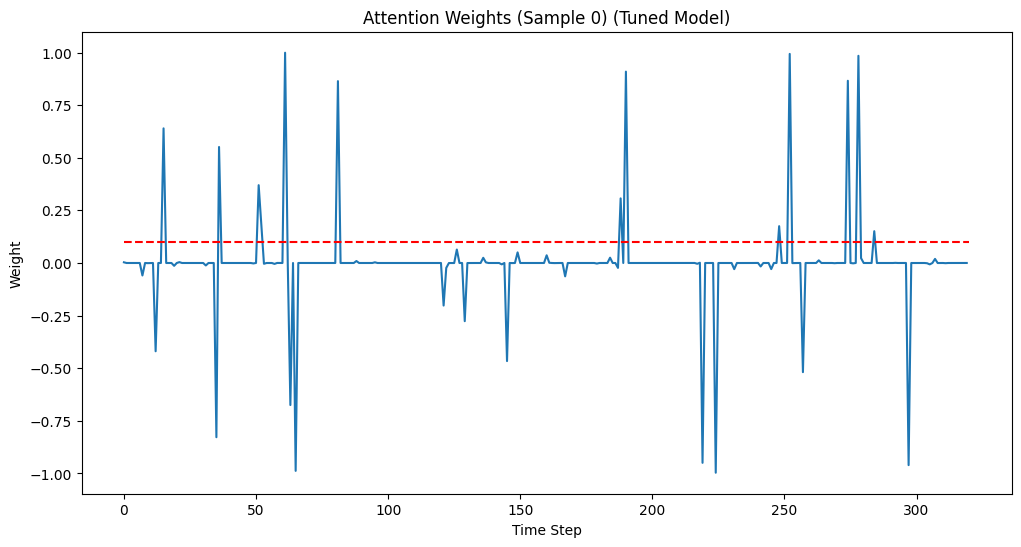

In [ ]:
# prompt: 위의 그래프에서 어느날짜의 어느 셀인지 알고 싶은데

# Load attention weights from file
attention_weights_save_path = "/content/drive/My Drive/lstm_tuner_attention_weights.npy"
attention_weights = np.load(attention_weights_save_path)

# 샘플 선택
sample_index = 0  # 분석할 샘플 인덱스

# 특정 임계값 이상의 어텐션 가중치를 가진 타임스텝 찾기
threshold = 0.1  # 임계값 설정 (필요에 따라 조정)
important_time_steps = np.where(attention_weights[sample_index] >= threshold)[0]

print(f"샘플 {sample_index}에서 어텐션 가중치가 {threshold} 이상인 타임스텝:")
print(important_time_steps)

# 시각화를 통해 확인
plt.figure(figsize=(12, 6))
plt.plot(attention_weights[sample_index])
plt.title(f"Attention Weights (Sample {sample_index}) (Tuned Model)")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.hlines(threshold, 0, len(attention_weights[sample_index]), colors='r', linestyles='dashed') # 임계값 표시
plt.show()


In [ ]:
# prompt: 중요하게 본 데이터가 어느 날짜의 어느 셀인지는 알 수 없는거야

# Load attention weights from file
attention_weights_save_path = "/content/drive/My Drive/lstm_tuner_attention_weights.npy"
attention_weights = np.load(attention_weights_save_path)

# Find the maximum attention weight and its index for each sample
max_attention_indices = np.argmax(attention_weights, axis=1)
max_attention_values = np.max(attention_weights, axis=1)

# Print the results
for i, (index, value) in enumerate(zip(max_attention_indices, max_attention_values)):
    print(f"Sample {i}: Maximum attention weight of {value:.4f} at time step {index}")


Sample 0: Maximum attention weight of 0.9992 at time step 61
Sample 1: Maximum attention weight of 0.9992 at time step 61
Sample 2: Maximum attention weight of 0.9992 at time step 61
Sample 3: Maximum attention weight of 0.9992 at time step 61
Sample 4: Maximum attention weight of 0.9992 at time step 61
Sample 5: Maximum attention weight of 0.9992 at time step 61
Sample 6: Maximum attention weight of 0.9992 at time step 61
Sample 7: Maximum attention weight of 0.9992 at time step 61
Sample 8: Maximum attention weight of 0.9992 at time step 61
Sample 9: Maximum attention weight of 0.9992 at time step 61
Sample 10: Maximum attention weight of 0.9992 at time step 61
Sample 11: Maximum attention weight of 0.9992 at time step 61
Sample 12: Maximum attention weight of 0.9992 at time step 61
Sample 13: Maximum attention weight of 0.9993 at time step 61
Sample 14: Maximum attention weight of 0.9993 at time step 61
Sample 15: Maximum attention weight of 0.9992 at time step 61
Sample 16: Maximum

In [ ]:
# prompt: 위의 셀에서 가장 많이 출력된 sample번호를 알려줘 sample번호를 보여달라고

import numpy as np

# Load attention weights from file
attention_weights_save_path = "/content/drive/My Drive/lstm_tuner_attention_weights.npy"
attention_weights = np.load(attention_weights_save_path)

# Find the maximum attention weight and its index for each sample
max_attention_indices = np.argmax(attention_weights, axis=1)

# Count the occurrences of each index
unique_indices, counts = np.unique(max_attention_indices, return_counts=True)

# Find the most frequent index
most_frequent_index = unique_indices[np.argmax(counts)]

print(f"The most frequent time step with the highest attention weight is: {most_frequent_index}")


The most frequent time step with the highest attention weight is: 61


In [ ]:
# prompt: 세션이 종료되서 아래의 셀에서 발생한 에러를 해결할 코드가 필요해

import tensorflow as tf
from google.colab import drive
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shap
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.mixed_precision import set_global_policy
import os
import keras_tuner as kt  # Keras Tuner import
from tensorflow.keras.regularizers import l2 # L2 Regularizer import

# Mount Google Drive
drive.mount('/content/drive')

# -------------------------------------------------------------------------------------
# 데이터 로드 및 전처리 (기존 코드와 동일)
# -------------------------------------------------------------------------------------
normal_data_arr = "/content/drive/My Drive/list/train_normal_arr.npy"
caution_data_arr = "/content/drive/My Drive/list/train_caution_arr.npy"
defect_data_arr = "/content/drive/My Drive/list/train_defect_arr.npy"

test_normal_data_arr = "/content/drive/My Drive/list/test_normal_arr.npy"
test_caution_data_arr = "/content/drive/My Drive/list/test_caution_arr.npy"
test_defect_data_arr = "/content/drive/My Drive/list/test_defect_arr.npy"

# Load data from the file paths using np.load
normal_arr = np.load(normal_data_arr)
caution_arr = np.load(caution_data_arr)
defect_arr = np.load(defect_data_arr)

test_normal_arr = np.load(test_normal_data_arr)
test_caution_arr = np.load(test_caution_data_arr)
test_defect_arr = np.load(test_defect_data_arr)

# 데이터 shape 확인
print("normal_arr shape:", normal_arr.shape)
print("caution_arr shape:", caution_arr.shape)
print("defect_arr shape:", defect_arr.shape)

# 슬라이딩 윈도우 생성 함수 (기존 코드와 동일)
def create_sliding_windows(arr, window_size=100, step=30):
    n_rows = arr.shape[0]
    windows = []
    for i in range(0, n_rows - window_size + 1, step):
        windows.append(arr[i:i+window_size])
    return np.array(windows)


# 학습 데이터 슬라이딩 윈도우 적용
normal_windows = create_sliding_windows(normal_arr, window_size=100, step=30)
caution_windows = create_sliding_windows(caution_arr, window_size=100, step=30)
defect_windows = create_sliding_windows(defect_arr, window_size=100, step=30)

# 테스트 데이터 슬라이딩 윈도우 적용
test_normal_windows = create_sliding_windows(test_normal_arr, window_size=100, step=30)
test_caution_windows = create_sliding_windows(test_caution_arr, window_size=100, step=30)
test_defect_windows = create_sliding_windows(test_defect_arr, window_size=100, step=30)

# 각 데이터별 라벨 생성
normal_labels = np.zeros(len(normal_windows))
caution_labels = np.ones(len(caution_windows))
defect_labels = np.full(len(defect_windows), 2)

test_normal_labels = np.zeros(len(test_normal_windows))
test_caution_labels = np.ones(len(test_caution_windows))
test_defect_labels = np.full(len(test_defect_windows), 2)

# 모든 윈도우 데이터를 concat (axis=0)하여 하나의 X 배열 생성
X_train = np.concatenate([normal_windows, caution_windows, defect_windows], axis=0)
y_train = np.concatenate([normal_labels, caution_labels, defect_labels], axis=0)

X_test = np.concatenate([test_normal_windows, test_caution_windows, test_defect_windows], axis=0)
y_test = np.concatenate([test_normal_labels, test_caution_labels, test_defect_labels], axis=0)

# X_train, y_train shape 확인
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# -------------------------------------------------------------------------------------
# 데이터 보강 (Scaling)
# -------------------------------------------------------------------------------------
def scale_data(arr, scale_factor=1.1):
    """데이터의 진폭을 변경합니다."""
    return arr * scale_factor

# 학습 데이터에 Scaling 적용 (일부 데이터에만 적용하여 데이터 불균형 해소)
num_to_augment = len(normal_windows) // 2  # Normal 데이터의 절반만 보강
augmented_normal_windows = scale_data(normal_windows[:num_to_augment])
X_train = np.concatenate([X_train, augmented_normal_windows], axis=0)
y_train = np.concatenate([y_train, np.zeros(len(augmented_normal_windows))], axis=0)

print("Augmented X_train shape:", X_train.shape)
print("Augmented y_train shape:", y_train.shape)

# MinMaxScaler를 사용하여 데이터 스케일링 (모델 학습 전에 수행)
scaler = MinMaxScaler()

# 2차원 형태로 변환 후 스케일링
original_shape = X_train.shape
X_train = X_train.reshape(-1, X_train.shape[-1])  # 2차원 형태로 변환
X_train = scaler.fit_transform(X_train)  # 스케일링 수행
X_train = X_train.reshape(original_shape)  # 원래 형태로 복원

original_shape_test = X_test.shape
X_test = X_test.reshape(-1, X_test.shape[-1])  # 2차원 형태로 변환
X_test = scaler.transform(X_test)  # 스케일링 수행
X_test = X_test.reshape(original_shape_test)  # 원래 형태로 복원

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
normal_arr shape: (770977, 98)
caution_arr shape: (584051, 98)
defect_arr shape: (584498, 98)
X_train shape: (64642, 100, 98)
y_train shape: (64642,)
X_test shape: (8101, 100, 98)
y_test shape: (8101,)
Augmented X_train shape: (77490, 100, 98)
Augmented y_train shape: (77490,)


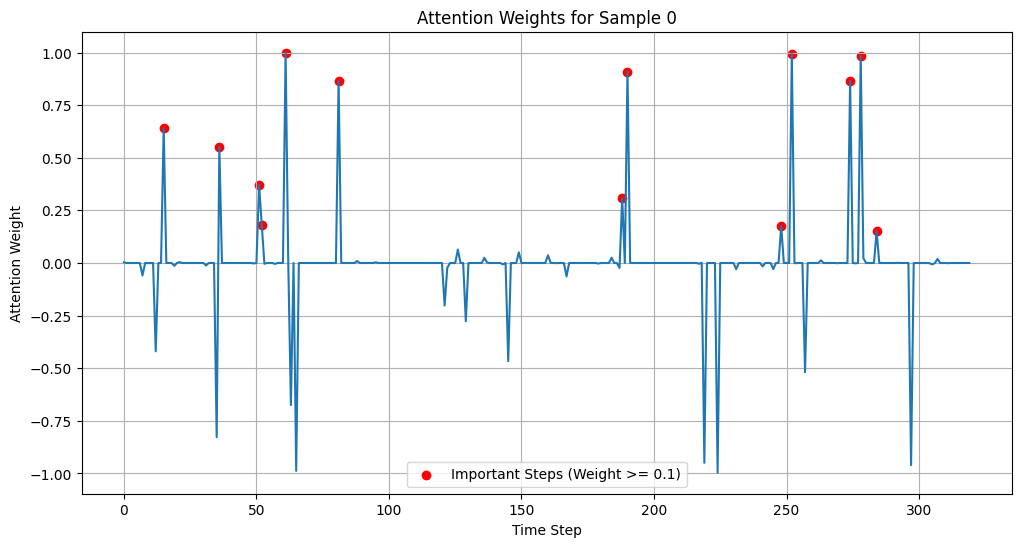

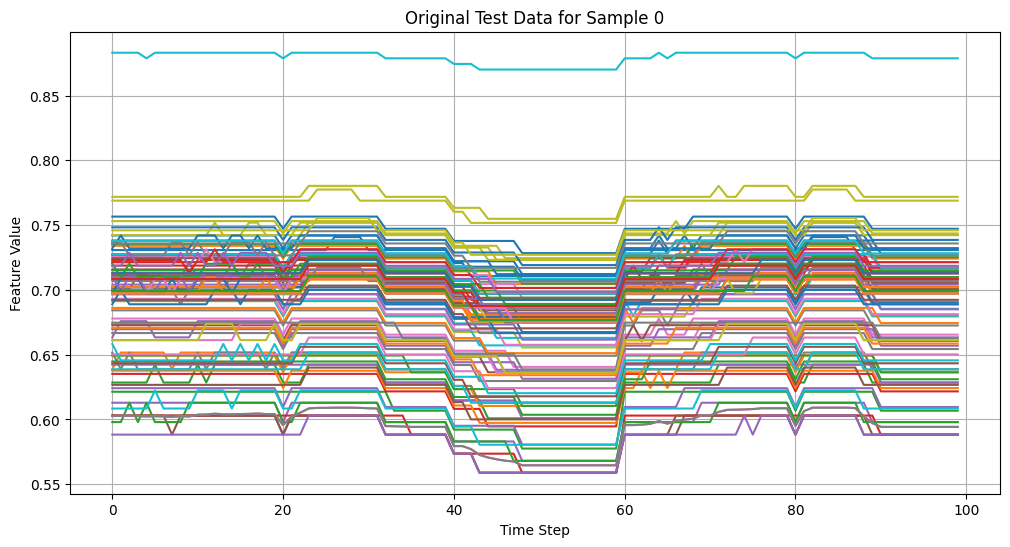

In [ ]:
# prompt: test데이터를 시각화 하고 거기에 중요하게 본 부분(어텐션가중치가 큰부분)을 알아볼 수 있게시각화해줘

import matplotlib.pyplot as plt

# Load attention weights from file
attention_weights_save_path = "/content/drive/My Drive/lstm_tuner_attention_weights.npy"
attention_weights = np.load(attention_weights_save_path)

# Select a sample for visualization
sample_index = 0  # Change this to visualize different samples

# Visualize attention weights for the selected sample
plt.figure(figsize=(12, 6))
plt.plot(attention_weights[sample_index])
plt.title(f"Attention Weights for Sample {sample_index}")
plt.xlabel("Time Step")
plt.ylabel("Attention Weight")
plt.grid(True)

# Highlight important time steps (e.g., those with attention weights above a threshold)
threshold = 0.1  # Adjust the threshold as needed
important_steps = np.where(attention_weights[sample_index] >= threshold)[0]
plt.scatter(important_steps, attention_weights[sample_index][important_steps], color='red', label=f'Important Steps (Weight >= {threshold})')

plt.legend()
plt.show()

# Optionally, visualize the original test data corresponding to the selected sample
plt.figure(figsize=(12, 6))
plt.plot(X_test[sample_index])  # Assuming X_test contains the original test data
plt.title(f"Original Test Data for Sample {sample_index}")
plt.xlabel("Time Step")
plt.ylabel("Feature Value")
plt.grid(True)
plt.show()


In [ ]:
# -------------------------------------------------------------------------------------
# SHAP 값과 Attention 가중치 연계 분석
# -------------------------------------------------------------------------------------
# 가장 높은 attention score를 가진 time step 찾기
time_step_index = np.argmax(attention_weights[sample_index])

# SHAP value를 time series 데이터 형태로 변환 (특정 클래스에 대한 SHAP value 선택)
predicted_class = np.argmax(y_pred[sample_index]) # 예측 클래스
shap_value_matrix = shap_values[predicted_class][sample_index]

# 선택한 time step의 SHAP value 출력
print(f"Sample Index: ")
print(f"가장 높은 Attention Score Time Step: ")
print(f"해당 Time Step Attention Score: {attention_weights[sample_index][time_step_index]}")
print(f"해당 Time Step SHAP Value:\n{shap_value_matrix[time_step_index]}")

NameError: name 'y_pred' is not defined

In [ ]:
# -------------------------------------------------------------------------------------
# 각 time step에 대한 SHAP value 영향력 시각화
# -------------------------------------------------------------------------------------
num_time_steps = X_test.shape[1]  # time step 개수

# 각 time step의 SHAP value 절대값 평균 계산
mean_abs_shap_values = np.mean(np.abs(shap_value_matrix), axis=1)

# Time step별 SHAP value 영향력 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(num_time_steps), mean_abs_shap_values)
plt.title("Mean Absolute SHAP Values per Time Step (Tuned Model)")
plt.xlabel("Time Step")
plt.ylabel("Mean Absolute SHAP Value")
plt.grid(True)
plt.show()

NameError: name 'X_test' is not defined

In [ ]:
# -------------------------------------------------------------------------------------
# Top N개의 time step에 대한 SHAP value 시각화
# -------------------------------------------------------------------------------------
top_n = 50  # 시각화할 top time step 개수

# Top N time step index 추출
top_time_indices = np.argsort(mean_abs_shap_values)[-top_n:]

# Top N time step SHAP value box plot 시각화
plt.figure(figsize=(12, 6))
plt.boxplot([shap_value_matrix[i] for i in top_time_indices], positions=top_time_indices)
plt.title(f"Top  Time Steps SHAP Values Box Plot (Tuned Model)")
plt.xlabel("Time Step Index")
plt.ylabel("SHAP Value")
plt.xticks(top_time_indices)
plt.grid(True)
plt.show()

# TensorFlow 세션 정리
tf.keras.backend.clear_session()

NameError: name 'mean_abs_shap_values' is not defined

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class FeatureAttentionLayer(Layer):
    def __init__(self):
        super(FeatureAttentionLayer, self).__init__()

    def build(self, input_shape):
        # 가중치 W: (특성 수, 1)
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal", trainable=True)
        # 편향 b: (특성 수, 1)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1], 1), initializer="zeros", trainable=True)

    def call(self, x):
        # 입력 x: (batch_size, time_steps, features)
        # Alignment scores 계산: (batch_size, time_steps, features)
        e = tf.keras.backend.tanh(tf.tensordot(x, self.W, axes=[2, 0]) + self.b)
        # Attention weights 계산: (batch_size, time_steps, features)
        a = tf.keras.backend.softmax(e, axis=-1)
        # 가중치 적용: (batch_size, time_steps, features)
        output = x * a
        return output